<a href="https://colab.research.google.com/github/GitMishka/2021_TSLAstock_Analysis-/blob/master/fake_twit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark flask faker flask-socketio eventlet
pip install matplotlib


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 5.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=34d15c2a502c50ab52d745109df5b0406be840cbc264889be71fcaeb971317cb
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [ ]:
from faker import Faker
fake = Faker()

def generate_fake_tweet():
    return {
        "username": fake.user_name(),
        "tweet": fake.text(),
        "hashtags": [f"#{fake.word()}", f"#{fake.word()}"]
    }


{'username': 'gbryant', 'tweet': 'Thing human reason help from stage space surface. Ten enter business serve.\nMilitary organization raise ago those. Century attack best cut.', 'hashtags': ['#they', '#add']}


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, col

# Create a SparkSession
spark = SparkSession.builder \
    .appName("Real-time Tweet Analysis") \
    .getOrCreate()

# Generate a static dataframe of tweets
data = [generate_fake_tweet() for _ in range(1000)]
df = spark.createDataFrame(data)

# Extract hashtags
df = df.select(explode(df.hashtags).alias("hashtag"))

# Compute hashtag counts
df = df.groupby("hashtag").count().sort(col("count").desc())


In [ ]:
from flask import Flask, render_template
from flask_socketio import SocketIO

# Create Flask app
app = Flask(__name__)
socketio = SocketIO(app)

@app.route("/")
def index():
    return render_template("index.html")


In [ ]:
# Emit top hashtags
top_hashtags = df.collect()
socketio.emit("hashtag update", top_hashtags)


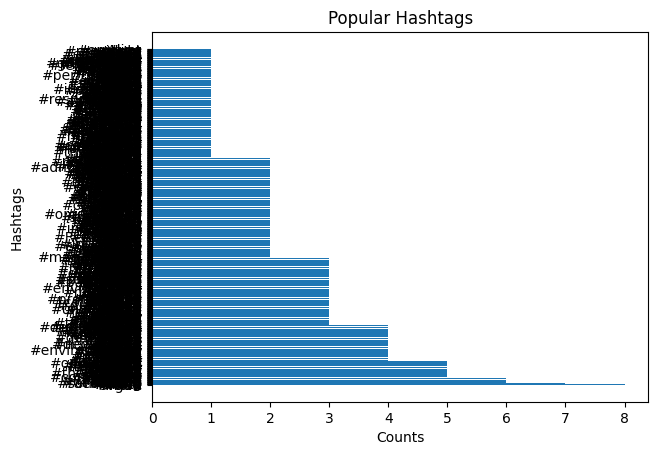

In [ ]:
import matplotlib.pyplot as plt

# Collect DataFrame to local node
top_hashtags = df.collect()

# Separate hashtags and counts into separate lists
hashtags = [row["hashtag"] for row in top_hashtags]
counts = [row["count"] for row in top_hashtags]

# Create bar chart
plt.bar(hashtags, counts)
plt.xlabel('Hashtags')
plt.ylabel('Counts')
plt.title('Popular Hashtags')
plt.xticks(rotation='vertical')
plt.figure(figsize=(10, 8)) # Adjust as necessary

plt.show()
